# Excercise 2

## Import packages

In [1]:
import numpy as np
import scipy.ndimage
import matplotlib.pyplot as plt

import skimage.io
import skimage.color
import skimage.exposure

import time
import math
import random

## Task 1
(2 points)
1. Use $f = loss(100)$ which creates a 1D array that mimics a loss curve of some neural network.
2. Implement the naive $\mathcal{O}(n w)$ mean filter to smooth the loss.
3. Implement the improved $\mathcal{O}(n)$ mean filter to smooth the loss.
4. Show all three curves in a single plot with a legend.
5. Compare the runtime between the naive and improved implementation.

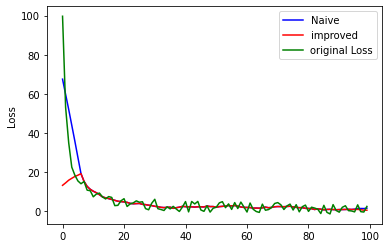

naive running time:  143.20731163024902 ms
naive running time / w:  28.641462326049805 ms
improved running time:  33.148765563964844 ms


In [2]:
# 1.
def loss(n):    
    return 1.0 / (0.01 * (np.arange(0, n) + 1)) + 3.0 * np.random.uniform(-1.00, 1.00, n)

# TODO: generate f with loss helper function

f = loss(100)

# 2.
def naive_running_mean(f, w):
    '''
    Apply the naive running mean filter and return the smoothed values.

    f -- contains the values
    w -- window size
    '''
    f_mean= np.zeros(len(f))
    
    for i in range(len(f)):
        f_sum = 0
        for j in range(i-w,i+w+1):
            if j<0:                      #clamp padding
                f_sum = f_sum + f[0]
            elif j >= len(f):
                f_sum = f_sum + f[len(f)-1]
            else:
                f_sum = f_sum + f[j]
                
        f_mean[i] = f_sum/(2*w+1)
    
    return f_mean

# 3.
def improved_running_mean(f, w):
    '''
    Apply the improved running mean filter and return the smoothed values.

    f -- contains the values
    w -- window size
    '''
    
    f_tilde = np.cumsum(f)    
    g = np.zeros(len(f))

    for i in range(len(f)):
        if i-w-1<0:                                                      #clamp padding
            g[i] = (f_tilde[i+w]-f_tilde[0])/(2*w+1)
        elif i+w >= len(f):
            g[i] = (f_tilde[len(f)-1]-f_tilde[i-w-1])/(2*w+1) 
        else:
            g[i] = (f_tilde[i+w]-f_tilde[i-w-1])/(2*w+1)
    
    return g

# 4.
ws = 5

# TODO: Plot all three curves in a single plot
plt.plot(np.arange(len(f)),naive_running_mean(f,ws),color="blue",label="Naive")
plt.plot(np.arange(len(f)),improved_running_mean(f,ws),color="red",label="improved")
plt.plot(np.arange(len(f)),f, label="original Loss",color="green")
plt.legend()
plt.ylabel("Loss")
plt.show()

# 5.
# TODO: Measure and print the runtime of both methods in Milliseconds
f= loss(10000)
t_start = time.time()
naive_running_mean(f,ws)
t_stop = time.time()
print("naive running time: ", (t_stop-t_start)*1000,"ms")
print("naive running time / w: ", (t_stop-t_start)*1000/ws,"ms")

t_start = time.time()
improved_running_mean(f,ws)
t_stop = time.time()
print("improved running time: ", (t_stop-t_start)*1000,"ms")

## Task 2
(4 points)
1. Create numpy arrays for the horizontal and vertical Sobel kernel.
$$
S_x =\begin{bmatrix}
-1 & -2 & -1 \\
0 & 0 & 0 \\
1 & 2 & 1
\end{bmatrix}
$$

$$
S_y =\begin{bmatrix}
-1 & 0 & 1 \\
-2 & 0 & 2 \\
-1 & 0 & 1
\end{bmatrix}
$$

2. Implement the $\textit{convolve}$ function with four nested loops.
3. Load the image from the last exercise and detect its edges using the Sobel kernels and the $\textit{convolve}$ function.
4. Implement the 1D $\textit{convolve_fast}$ function. Apply the seperated Sobel operators $u$ and $v$. Plot the result together with $\textit{convolve(S_x)}$ and compare the runtime.
5. Implement a function that seperates a 2D kernel into 2 1D kernels.
6. (Bonus) Use the function for a gaussian blur kernel and apply it on the image.

In [3]:
# 1
# TODO Create S_x and S_y

S_x = np.array([[-1,-2,-1],[0,0,0],[1,2,1]])
S_y = np.array([[-1,0,1],[-2,0,2],[-1,0,1]])


print('Horizontal Sobel kernel:\n', S_x)
print('Vertical Sobel kernel:\n', S_y)

Horizontal Sobel kernel:
 [[-1 -2 -1]
 [ 0  0  0]
 [ 1  2  1]]
Vertical Sobel kernel:
 [[-1  0  1]
 [-2  0  2]
 [-1  0  1]]


In [4]:
# 2
def convolve(arr, ker):
    '''
    Convolve the array using kernel K with four nested for loops.
    
    arr -- 2D array that gets convolved
    ker   -- kernel
    '''
    
    arr_conv = np.zeros_like(arr)
    for im_row in range(len(arr)):
        for i in range(len(arr[0])):
            sum = 0
            for ker_row in range(int((-len(ker)-1)/2), int((len(ker)-1)/2)):
                for j in range(int((-len(ker[0])-1)/2), int((len(ker[0])-1)/2)):
                    
                    if im_row + ker_row < 0 and i+j < 0 :
                        sum = sum + arr[0][0]* ker[ker_row][j]
                        
                    elif im_row + ker_row < 0 and i+j >= 0 :
                        sum = sum + arr[0][i+j]* ker[ker_row][j]
                        
                    elif im_row + ker_row >= 0 and i+j < 0 :
                        sum = sum + arr[im_row + ker_row][0]* ker[ker_row][j]
                        
                    elif im_row + ker_row >= len(arr) and i+j >= len(arr[0]) :
                        sum = sum + arr[len(arr)][len(arr[0])]* ker[ker_row][j]
                        
                    elif im_row + ker_row >= len(arr) and i+j < len(arr[0]) :
                        sum = sum + arr[len(arr)][i+j]* ker[ker_row][j]
                        
                    elif im_row + ker_row < len(arr) and i+j >= len(arr[0]) :
                        sum = sum + arr[im_row+ker_row][len(arr[0])]* ker[ker_row][j]
                    
                    else:
                        sum = sum + arr[im_row+ker_row][i+j]* ker[ker_row][j]
                    
            arr_conv[im_row][i] = sum
    
    return arr_conv

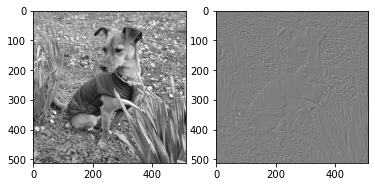

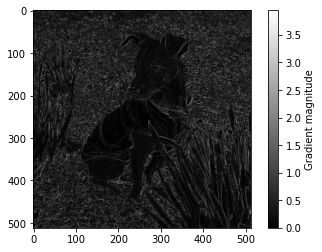

In [5]:
# 3
# TODO: load ./data/pepo.jpg as a grayscale image
image = skimage.io.imread("./data/pepo.jpg", as_gray=True)


# TODO: Use the Sobel filter for edge detection:
#       Compute the Gradient Magnitude using both Sobel kernels

edges_x = convolve(image, S_x)
edges_y = convolve(image, S_y)

edges = edges_x + edges_y


# Show results
_, axis = plt.subplots(1, 2)
axis[0].imshow(image, cmap='gray')
axis[1].imshow(edges,cmap='gray')
plt.show()

#       Compute the Gradient Magnitude using both Sobel kernels

plt.imshow(np.abs(edges),cmap="gray")
plt.colorbar(label="Gradient magnitude")
plt.show()

u   =
 [[1]
 [2]
 [1]]
v   =
 [[-1  0  1]]
S_x =
 [[-1  0  1]
 [-2  0  2]
 [-1  0  1]]
naive implementation: 14.684377670288086 s
improved implementation: 3.9248692989349365 s


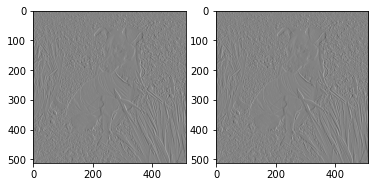

In [6]:
# 4
u = np.array([[1], [2], [1]])
v = np.array([[-1, 0, 1]])
S_x = np.dot(u, v)
print('u   =\n', u)
print('v   =\n', v)
print('S_x =\n', S_x)

def convolve_1d_ker(arr,ker):
        
    '''
    Convolve the array using kernel K 
    
    arr -- 1D array that gets convolved
    ker   -- kernel
    '''
    
    arr_conv = np.zeros_like(arr)
    
    for i in range(len(arr)):
        sum=0
        for j in range(int((-len(ker)-1)/2), int((len(ker)-1)/2)):
            if i+j < 0 :
                sum = sum + arr[0]*ker[j]

            elif i+j >=  len(arr):
                sum = sum + arr[len(arr)]*ker[j]

            else:
                sum = sum + arr[i+j]*ker[j]        
            
        arr_conv[i] = sum
        
    return arr_conv

def convolve_fast(arr, K_u, K_v):
    '''
    Convolve the array using kernel K_u and K_v.
    
    arr -- 2D array that gets convolved
    K_u -- kernel u
    K_v -- kernel v
    '''
    g = np.zeros_like(arr)
    for i in range(len(arr)):
        g[:,i] = convolve_1d_ker(arr[:,i],K_u[:,0])
        
    for j in range(len(arr[0])):
        g[j,:] = convolve_1d_ker(g[j,:],K_v[0,:])

    return g

# TODO: Run both methods and compare their runtime

t_start = time.time()
edges_naive = convolve(image, S_x)
t_stop = time.time()
print("naive implementation:",t_stop-t_start,"s")

t_start = time.time()
edges_improved = convolve_fast(image, u, v)
t_stop = time.time()
print("improved implementation:",t_stop-t_start,"s")

# Show results
_, axis = plt.subplots(1, 2)
axis[0].imshow(edges_naive, cmap='gray')
axis[1].imshow(edges_improved,cmap='gray')

plt.show()

In [7]:
# 5
print('rank of s_x:', np.linalg.matrix_rank(S_x))
print('rank of s_y:', np.linalg.matrix_rank(S_y))

def separate(K):
    '''
    Seperate the 2D kernel into 2 1D kernels.
    
    K -- 2D kernel
    '''
    u, s, vh = np.linalg.svd(K)
    K_u = np.zeros((len(K),1))
    K_u[:,0] = u[:,0] 
    K_v = np.zeros((1,len(K[1])))
    K_v[0] = vh[0]*s[0] 
    
    return K_u, K_v

K_u, K_v = separate(S_x)
print('K_u =\n', K_u)
print('K_v =\n', K_v)
print('K   =\n', np.dot(K_u, K_v))

rank of s_x: 1
rank of s_y: 1
K_u =
 [[-0.40824829]
 [-0.81649658]
 [-0.40824829]]
K_v =
 [[ 2.44948974  0.         -2.44948974]]
K   =
 [[-1.  0.  1.]
 [-2.  0.  2.]
 [-1.  0.  1.]]


In [8]:
# 6 Bonus
def gaussian_kernel(kernel_size, sigma):
    '''
    Return a 2D gaussian kernel.
    
    kernel_size -- size of the kernel
    sigma       -- sigma of the gaussian blur
    '''
   
    return h

K = gaussian_kernel(15, 15)

K_u, K_v = separate(K)

# TODO: Run both methods and compare their runtime

# Plot the results
_, axis = plt.subplots(1, 2)
axis[0].imshow(conv_x_naive, cmap='gray')
axis[1].imshow(conv_x_improved,cmap='gray')
plt.show()

NameError: name 'h' is not defined

## Task 3
(4 points)

1. Implement the naive max function using nested loops.
2. Implement the $\mathcal{O}(n log w)$ faster max function using a binary tree.

In [9]:
#1
def naive_max(arr, ws):
    '''
    Return the maximum-filtered array
    
    arr -- 2D array
    ws -- window size
    '''
    g = np.zeros_like(arr)
    for x in range(ws,len(arr)-ws):
        max_val = -np.inf # negative infinity
        for k in range(x-ws, x+ws+1):
            if arr[k] > max_val:
                max_val = arr[k]
        g[x] = max_val
            
    return g

# Generate some random data to filter
f = []
for i in range(25):
    f.append(random.randint(0, 100))

print('input = ', f)
print('naive_max =', naive_max(f, 3))

input =  [88, 29, 12, 46, 21, 80, 97, 11, 34, 33, 2, 56, 53, 26, 40, 44, 70, 95, 23, 70, 59, 11, 74, 19, 57]
naive_max = [ 0  0  0 97 97 97 97 97 97 97 56 56 56 70 95 95 95 95 95 95 95 74  0  0
  0]


In [10]:
#2
class Node:
    def __init__(self):
        self.max = -np.inf # value of this node
        self.top = None    # reference to parent node
        self.left = None   # left child node
        self.right = None  # right child node
        
        # HINT: this list will hold a reference to all leaf nodes that
        #       are children of this node.
        #       You will need later to add new and replace old values
        #       in the tree.
        self.elems = []    # list of all child leaf nodes
    
    
    def build_tree(self, depth, top=None):
        '''
        Build up a tree of certain depth
        
        depth -- tree depth (integer >= 0)
        top -- parent node
        '''
        self.top = top
        
        if depth > 0:
            # recursively initialize all children
            # additional nodes with -inf don't matter -> always new left and right node -> balanced tree 
            self.left = Node()
            self.right = Node()
            
            left_elems = self.left.build_tree(depth-1, top=self)
            right_elems = self.right.build_tree(depth-1, top=self)
           
            
            # concatenate elems lists of children
            # HINT: nodes that are not leafes should not be added
            #       to self.elems
            
            self.elems.extend(left_elems)
            self.elems.extend(right_elems)
            
        
        else:
            # this is a leaf node
            # HINT: this node has to be added to the elems list
            
            self.elems.append(self)
            
        
        return self.elems
    
    
    def update(self):
        '''
        Update the value (self.max) of this node
        and its parent nodes recursively
        '''
        if self.left != None:
            self.max = max(self.left.max, self.right.max)
        if self.top != None:
            self.top.update()
        pass


class MaxTree:
    def __init__(self, ws):
        '''
        ws -- window size
        '''
        # compute number of leafes and tree depth (length = 2 * ws + 1)
        # number of leaves = next power of 2 after length
        # depth = log_2(number of leaves)
        self.window_length = 2*ws+1
        depth = np.ceil(np.log2(self.window_length))
        # optional:
        num_leaves = np.power(2, depth)
        
        # initialize root node
        self.root = Node()
        self.root.build_tree(depth)
                
        # init pointer to next element to be replaced
        self.ptr = 0
        
    def replace_elem(self, value):
        '''
        Replace an element (value of leaf node) in the tree

        value -- value of new element
        '''
        # HINT: use self.ptr as a pointer to the next
        #       element that has to be replaced
        self.root.elems[self.ptr].max = value
        self.root.elems[self.ptr].update()
        
        # don't iterate over too many leaves
        self.ptr = (self.ptr + 1) % self.window_length
        
        pass
    
    # for testing
    def get_leafe_values(self):
        values = []
        for node in self.root.elems:
            values.append(node.max)
        return values

    
    def get_max(self):
        return self.root.max

# tree = MaxTree(3)

def fast_max(arr, ws):
    '''
    Return the maximum-filtered array
    
    arr -- 2D array
    ws -- window size
    '''
    max_arr = np.zeros_like(arr)
    
    # initialize tree
    tree = MaxTree(ws)
    for x in range(2*ws):
        tree.replace_elem(arr[x])
    
    
    # compute maximum-filtered output array
    for x in range(ws,len(arr)-ws):
        tree.replace_elem(arr[x+ws])
        max_arr[x] = tree.get_max()
    
    
    return max_arr


print('input = ', f)
print('fast_max =', fast_max(f, 3))
print('naive_max =', naive_max(f,3))

input =  [88, 29, 12, 46, 21, 80, 97, 11, 34, 33, 2, 56, 53, 26, 40, 44, 70, 95, 23, 70, 59, 11, 74, 19, 57]
fast_max = [ 0  0  0 97 97 97 97 97 97 97 56 56 56 70 95 95 95 95 95 95 95 74  0  0
  0]
naive_max = [ 0  0  0 97 97 97 97 97 97 97 56 56 56 70 95 95 95 95 95 95 95 74  0  0
  0]


We now use your implementation to filter an image with different window sizes.
Note, that for small windows, the naive method is indeed faster due to the lower overhead.
However, as it has a much better time complexity, the tree method is much faster for large windows.


Filter with window size 2
Naive implementation took 2301.320 ms
Improved implementation took 3604.475 ms


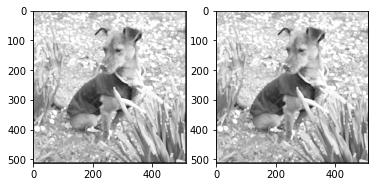


Filter with window size 4
Naive implementation took 3238.551 ms
Improved implementation took 4748.322 ms


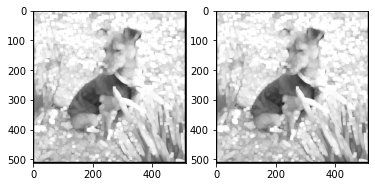


Filter with window size 8
Naive implementation took 4686.396 ms
Improved implementation took 5061.338 ms


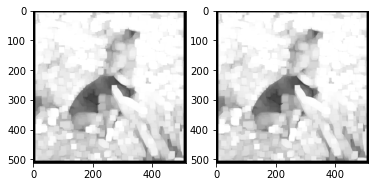


Filter with window size 16
Naive implementation took 7854.703 ms
Improved implementation took 6268.801 ms


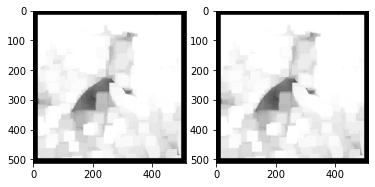


Filter with window size 32
Naive implementation took 13768.387 ms
Improved implementation took 7831.979 ms


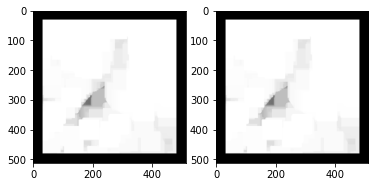

In [11]:
# Nothing to do here ;)
def image_max(arr, ws, method):
    '''
    Apply a max-filter to an image
    
    arr -- input image
    ws -- window size
    method -- filter function
    '''
    out = np.zeros_like(arr)
    
    for y in range(arr.shape[0]):
        out[y] = method(arr[y], ws)
    
    for x in range(arr.shape[1]):
        out[:, x] = method(out[:, x], ws)
    
    
    return out

for ws in [2, 4, 8, 16, 32]:
    print('\nFilter with window size {}'.format(ws))
    start_time = time.time()
    max_img_naive = image_max(image, ws, naive_max)
    naive_time = time.time() - start_time
    print('Naive implementation took {:.3f} ms'.format(1000 * naive_time))

    start_time = time.time()
    max_img_improved = image_max(image, ws, fast_max)
    improved_time = time.time() - start_time
    print('Improved implementation took {:.3f} ms'.format(1000 * improved_time))

    _, axis = plt.subplots(1, 2)
    axis[0].imshow(max_img_naive, cmap='gray')
    axis[1].imshow(max_img_improved,cmap='gray')
    plt.show()